In [1]:
# ============================================
# 0. INSTALLS (run once per session)
# ============================================
!pip install -q "transformers>=4.46.0" "mistral_common[audio]>=1.8.6" \
              "accelerate>=0.34.0" einops pandas soundfile seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 88.3 MB/s eta 0:00:00


In [2]:
# ============================================
# 1. IMPORTS & DEVICE
# ============================================
import os, json, re
from typing import List, Dict

import numpy as np
import pandas as pd
import soundfile as sf
from tqdm.auto import tqdm

import torch
from transformers import VoxtralForConditionalGeneration, AutoProcessor

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef,
)

import matplotlib.pyplot as plt
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [3]:
# ============================================
# 2. MOUNT DRIVE & DEFINE PATHS
# ============================================
from google.colab import drive
drive.mount("/content/drive")

BASE = "/content/drive/MyDrive/adsp"  # adjust ONLY if your 'adsp' folder is elsewhere

EMOBOX_ROOT    = os.path.join(BASE, "EmoBox")
IEMOCAP_EMOBOX = os.path.join(EMOBOX_ROOT, "data", "iemocap")
IEMOCAP_RAW    = os.path.join(BASE, "downloads", "iemocap")
TRANSCRIPT_CSV = os.path.join(IEMOCAP_RAW, "txt", "iemocap_transcriptions.csv")

FOLD_ID = 1  # which EmoBox test fold to use (1..5)
TEST_JSON = os.path.join(
    IEMOCAP_EMOBOX, f"fold_{FOLD_ID}", f"iemocap_test_fold_{FOLD_ID}.json"
)

print("EMOBOX_ROOT    :", EMOBOX_ROOT)
print("IEMOCAP_EMOBOX :", IEMOCAP_EMOBOX)
print("IEMOCAP_RAW    :", IEMOCAP_RAW)
print("TRANSCRIPT_CSV :", TRANSCRIPT_CSV)
print("TEST_JSON      :", TEST_JSON)

for p in [EMOBOX_ROOT, IEMOCAP_EMOBOX, IEMOCAP_RAW, TRANSCRIPT_CSV, TEST_JSON]:
    assert os.path.exists(p), f"Missing path: {p}"


Mounted at /content/drive
EMOBOX_ROOT    : /content/drive/MyDrive/adsp/EmoBox
IEMOCAP_EMOBOX : /content/drive/MyDrive/adsp/EmoBox/data/iemocap
IEMOCAP_RAW    : /content/drive/MyDrive/adsp/downloads/iemocap
TRANSCRIPT_CSV : /content/drive/MyDrive/adsp/downloads/iemocap/txt/iemocap_transcriptions.csv
TEST_JSON      : /content/drive/MyDrive/adsp/EmoBox/data/iemocap/fold_1/iemocap_test_fold_1.json


In [4]:
# ============================================
# 3. LOAD EMOBOX TEST FOLD (AUDIO + LABELS)
# ============================================

with open(TEST_JSON, "r") as f:
    test_dict = json.load(f)  # key -> { 'wav': 'downloads/iemocap/...wav', 'emo': 'ang', ... }

df_test_raw = (
    pd.DataFrame.from_dict(test_dict, orient="index")
      .reset_index()
      .rename(columns={"index": "key"})
)

print("RAW EmoBox test shape:", df_test_raw.shape)
display(df_test_raw.head(3))

# sanity: keys must be unique
assert df_test_raw["key"].is_unique, "Non-unique keys in test JSON."

# build absolute audio paths
def abs_audio(rel_path: str) -> str:
    """
    EmoBox 'wav' looks like:
    'downloads/iemocap/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F000.wav'
    Raw IEMOCAP audio root is: BASE/downloads/iemocap/Session1/...
    """
    rel = str(rel_path)
    prefix = "downloads/iemocap/"
    if rel.startswith(prefix):
        rel = rel[len(prefix):]
    return os.path.join(IEMOCAP_RAW, rel)

df_test_raw["audio_path"] = df_test_raw["wav"].astype(str).apply(abs_audio)
df_test = df_test_raw[df_test_raw["audio_path"].apply(os.path.exists)].reset_index(drop=True)
missing = len(df_test_raw) - len(df_test)

print(f"\nAfter audio existence check: kept {len(df_test)} / {len(df_test_raw)} (missing {missing})")
display(df_test[["key", "audio_path", "emo"]].head(3))

# utt_id from wav filename: 'Ses01F_impro04_F000.wav' -> 'Ses01F_impro04_F000'
df_test["utt_id"] = df_test["wav"].apply(
    lambda p: os.path.splitext(os.path.basename(p))[0]
)
display(df_test[["key", "utt_id", "emo"]].head(5))


RAW EmoBox test shape: (1085, 6)


,key,wav,length,emo,dataset,channel
0,iemocap-Ses01F_impro04_F000,downloads/iemocap/Session1/sentences/wav/Ses01...,4.394500,neu,iemocap,1
1,iemocap-Ses01F_impro04_F001,downloads/iemocap/Session1/sentences/wav/Ses01...,4.405125,neu,iemocap,1
2,iemocap-Ses01F_impro04_F005,downloads/iemocap/Session1/sentences/wav/Ses01...,2.409562,neu,iemocap,1



After audio existence check: kept 1085 / 1085 (missing 0)


,key,audio_path,emo
0,iemocap-Ses01F_impro04_F000,/content/drive/MyDrive/adsp/downloads/iemocap/...,neu
1,iemocap-Ses01F_impro04_F001,/content/drive/MyDrive/adsp/downloads/iemocap/...,neu
2,iemocap-Ses01F_impro04_F005,/content/drive/MyDrive/adsp/downloads/iemocap/...,neu


,key,utt_id,emo
0,iemocap-Ses01F_impro04_F000,Ses01F_impro04_F000,neu
1,iemocap-Ses01F_impro04_F001,Ses01F_impro04_F001,neu
2,iemocap-Ses01F_impro04_F005,Ses01F_impro04_F005,neu
3,iemocap-Ses01F_impro04_F006,Ses01F_impro04_F006,neu
4,iemocap-Ses01F_impro04_F009,Ses01F_impro04_F009,neu


In [5]:
# ============================================
# 4. LOAD TRANSCRIPTS & JOIN WITH TEST
# ============================================
df_txt = pd.read_csv(TRANSCRIPT_CSV)
print("Transcript CSV columns:", df_txt.columns.tolist())
display(df_txt.head(5))

assert {"file_name", "transcription"}.issubset(df_txt.columns)

# CSV file_name is already 'Ses01F_impro01_F000'; treat it as utt_id directly
df_txt["utt_id"] = df_txt["file_name"].astype(str)
df_txt = df_txt[["utt_id", "transcription"]].copy()

# inner join: EmoBox test (audio+labels) ∩ transcripts
df = df_test.merge(df_txt, on="utt_id", how="inner")

print("\nRows after joining test with transcripts:", len(df))
assert len(df) > 0, "Join with transcripts produced 0 rows – check ids."
display(df[["utt_id", "audio_path", "emo", "transcription"]].head(5))


Transcript CSV columns: ['file_name', 'transcription']


,file_name,transcription
0,Ses01F_impro01_F000,Excuse me.
1,Ses01F_impro01_M000,Do you have your forms?
2,Ses01F_impro01_F001,Yeah.
3,Ses01F_impro01_M001,Let me see them.
4,Ses01F_impro01_F002,Is there a problem?



Rows after joining test with transcripts: 1085


,utt_id,audio_path,emo,transcription
0,Ses01F_impro04_F000,/content/drive/MyDrive/adsp/downloads/iemocap/...,neu,"Uh, what? Craig's List? Oh the internet thing?"
1,Ses01F_impro04_F001,/content/drive/MyDrive/adsp/downloads/iemocap/...,neu,I don't know. Isn't that-- that's all like es...
2,Ses01F_impro04_F005,/content/drive/MyDrive/adsp/downloads/iemocap/...,neu,He just...
3,Ses01F_impro04_F006,/content/drive/MyDrive/adsp/downloads/iemocap/...,neu,you know what? I heard about that job. I app...
4,Ses01F_impro04_F009,/content/drive/MyDrive/adsp/downloads/iemocap/...,neu,Yeah.


In [6]:
# ============================================
# 5. LABEL MAPPING + DEFINE df_eval
# ============================================

# starting df columns we care about:
# ['utt_id', 'audio_path', 'emo', 'transcription', ...]

df["raw_label"] = df["emo"].astype(str).str.lower()

raw2canon = {
    "ang": "anger",
    "hap": "happiness",
    "exc": "happiness",  # excited -> happiness
    "sad": "sadness",
    "neu": "neutral",
}

# keep only the 4 emotions we care about
df = df[df["raw_label"].isin(raw2canon.keys())].reset_index(drop=True)
df["label"] = df["raw_label"].map(raw2canon)

TARGET_LABELS = ["anger", "happiness", "sadness", "neutral"]
print("\nLabel distribution (IEMOCAP test, mapped):")
print(df["label"].value_counts())

# final evaluation dataframe
df_eval = df.copy().reset_index(drop=True)
print("\nEval size:", len(df_eval))
print(df_eval["label"].value_counts())



Label distribution (IEMOCAP test, mapped):
label
neutral      384
happiness    278
anger        229
sadness      194
Name: count, dtype: int64

Eval size: 1085
label
neutral      384
happiness    278
anger        229
sadness      194
Name: count, dtype: int64


In [7]:
# ============================================
# 5. LABEL MAPPING  + DEFINE df_eval
# ============================================

# we start from df that already has: ['utt_id', 'audio_path', 'emo', 'transcription']

df["raw_label"] = df["emo"].astype(str).str.lower()

raw2canon = {
    "ang": "anger",
    "hap": "happiness",
    "exc": "happiness",   # excited -> happiness
    "sad": "sadness",
    "neu": "neutral",
}

# keep only the 4 emotions
df = df[df["raw_label"].isin(raw2canon.keys())].reset_index(drop=True)
df["label"] = df["raw_label"].map(raw2canon)

TARGET_LABELS = ["anger", "happiness", "sadness", "neutral"]

print("\nLabel distribution (IEMOCAP test, mapped):")
print(df["label"].value_counts())

# if you want the **full EmoBox test set** → no subsampling
df_eval = df.copy().reset_index(drop=True)

print("\nEval size:", len(df_eval))
print(df_eval["label"].value_counts())



Label distribution (IEMOCAP test, mapped):
label
neutral      384
happiness    278
anger        229
sadness      194
Name: count, dtype: int64

Eval size: 1085
label
neutral      384
happiness    278
anger        229
sadness      194
Name: count, dtype: int64


In [8]:
import torch
from transformers import AutoProcessor, VoxtralForConditionalGeneration

# Path where you moved the model in Google Drive
LOCAL_MODEL_DIR = "/content/drive/MyDrive/adsp/models/voxtral-mini-3b"

# Decide device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

processor = AutoProcessor.from_pretrained(
    LOCAL_MODEL_DIR,
    trust_remote_code=True,
)

model = VoxtralForConditionalGeneration.from_pretrained(
    LOCAL_MODEL_DIR,
    torch_dtype=torch.float16 if device.type == "cuda" else torch.float32,
    device_map="auto" if device.type == "cuda" else {"": "cpu"},
    trust_remote_code=True,
)

model.eval()


Using device: cuda


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

VoxtralForConditionalGeneration(
  (audio_tower): VoxtralEncoder(
    (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 1280)
    (layers): ModuleList(
      (0-31): 32 x VoxtralEncoderLayer(
        (self_attn): VoxtralAttention(
          (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
          (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (final_layer_norm): LayerNorm((1280,), ep

In [10]:
# ============================================
# 7. LABEL NORMALIZATION (HARDER)
# ============================================

import re

# Canonical labels used in your evaluation
# (must match the labels in your dataset / LABEL column)
LABEL_LIST = ["neutral", "anger", "happiness", "sadness"]

LABELS_LOWER = [l.lower() for l in LABEL_LIST]

def normalize_label_from_text(txt: str) -> str:
    """
    Map Voxtral's free text output back to one of LABEL_LIST.
    Strategy:
      1) Exact match (full string).
      2) Last token match + simple synonyms.
      3) Whole-word search for canonical labels or simple synonyms.
      4) Fallback: 'neutral' (conservative).
    """
    if txt is None:
        return "neutral"

    t = txt.strip().lower()
    if not t:
        return "neutral"

    # 1) exact string
    for lab in LABELS_LOWER:
        if t == lab:
            return lab

    # 2) last token
    tokens = [tok for tok in re.split(r"\W+", t) if tok]
    if tokens:
        last = tokens[-1]

        # exact last-token match
        for lab in LABELS_LOWER:
            if last == lab:
                return lab

        # simple synonyms on last token
        if last == "angry":
            return "anger"
        if last == "happy":
            return "happiness"
        if last == "sad":
            return "sadness"

    # 3) whole-word search anywhere in text
    for lab in LABELS_LOWER:
        if re.search(rf"\b{lab}\b", t):
            return lab

    # more synonyms anywhere in text
    if re.search(r"\bangry\b", t):
        return "anger"
    if re.search(r"\bhappy\b", t):
        return "happiness"
    if re.search(r"\bsad\b", t):
        return "sadness"

    # 4) fallback – to keep evaluation stable
    return "neutral"


In [11]:
# ============================================
# 8. PROMPT & SINGLE-SAMPLE PREDICTOR
# ============================================

def build_instruction(use_text: bool) -> str:
    label_str = ", ".join(LABEL_LIST)
    base = (
        "You are an emotion classifier for speech.\n"
        f"Possible emotions: {label_str}.\n"
        "From the given audio"
    )
    if use_text:
        base += " and its transcript"
    base += (
        ", classify the SPEAKER's emotion.\n"
        "Answer with EXACTLY one word from this set: "
        "anger, happiness, sadness, neutral.\n"
        "Do not add extra words, punctuation, or explanations."
    )
    return base


def voxtral_predict(
    audio_path: str,
    transcript: str | None = None,
    use_text: bool = False,
    max_new_tokens: int = 3,
) -> str:
    """
    Zero-shot emotion prediction for a single sample.
    use_text = False -> audio only
    use_text = True  -> audio + transcript
    """
    file_url = "file://" + os.path.abspath(audio_path)

    instruction = build_instruction(use_text)

    user_content = [
        {"type": "audio_url", "audio_url": file_url},
        {"type": "text", "text": instruction},
    ]

    if use_text and transcript is not None and transcript.strip():
        user_content.append(
            {"type": "text", "text": f"\nTranscript:\n{transcript}"}
        )

    conversation = [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": "You are a careful and concise emotion classification assistant.",
                }
            ],
        },
        {
            "role": "user",
            "content": user_content,
        },
    ]

    inputs = processor.apply_chat_template(
        conversation,
        tokenize=True,
        return_tensors="pt",
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,      # <- use sampling (chat mode)
            temperature=0.2,     # <- from Voxtral model card
            top_p=0.95,
        )

    new_tokens = outputs[:, inputs["input_ids"].shape[1]:]
    decoded = processor.batch_decode(new_tokens, skip_special_tokens=True)[0]
    return normalize_label_from_text(decoded)


# quick sanity check
row = df_eval.iloc[0]
print("\n=== Sanity check on one IEMOCAP sample ===")
print("utt_id     :", row["utt_id"])
print("Audio path :", row["audio_path"])
print("Transcript :", row["transcription"])
print("Gold label :", row["label"])
print("Pred (audio only)  :", voxtral_predict(row["audio_path"], use_text=False))
print("Pred (audio+text)  :", voxtral_predict(row["audio_path"], row["transcription"], use_text=True))



=== Sanity check on one IEMOCAP sample ===
utt_id     : Ses01F_impro04_F000
Audio path : /content/drive/MyDrive/adsp/downloads/iemocap/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F000.wav
Transcript : Uh, what?  Craig's List?  Oh the internet thing?
Gold label : neutral
Pred (audio only)  : neutral
Pred (audio+text)  : neutral


In [12]:
# ============================================
# 9. RUN ZERO-SHOT ON EVAL SET (LOOP VERSION)
# ============================================
pred_audio   = []
pred_bimodal = []

print("Running zero-shot inference on", len(df_eval), "utterances...")

for _, row in tqdm(df_eval.iterrows(), total=len(df_eval)):
    a_path = row["audio_path"]
    txt    = row.get("transcription", "")

    # audio only
    pa = voxtral_predict(a_path, transcript=None, use_text=False)

    # audio + transcript
    pb = voxtral_predict(a_path, transcript=txt, use_text=True)

    pred_audio.append(pa)
    pred_bimodal.append(pb)

df_eval["pred_audio"]   = pred_audio
df_eval["pred_bimodal"] = pred_bimodal

display(df_eval.head())


Running zero-shot inference on 1085 utterances...


  0%|          | 0/1085 [00:00<?, ?it/s]

,key,wav,length,emo,dataset,channel,audio_path,utt_id,transcription,raw_label,label,pred_audio,pred_bimodal
0,iemocap-Ses01F_impro04_F000,downloads/iemocap/Session1/sentences/wav/Ses01...,4.394500,neu,iemocap,1,/content/drive/MyDrive/adsp/downloads/iemocap/...,Ses01F_impro04_F000,"Uh, what? Craig's List? Oh the internet thing?",neu,neutral,neutral,neutral
1,iemocap-Ses01F_impro04_F001,downloads/iemocap/Session1/sentences/wav/Ses01...,4.405125,neu,iemocap,1,/content/drive/MyDrive/adsp/downloads/iemocap/...,Ses01F_impro04_F001,I don't know. Isn't that-- that's all like es...,neu,neutral,neutral,neutral
2,iemocap-Ses01F_impro04_F005,downloads/iemocap/Session1/sentences/wav/Ses01...,2.409562,neu,iemocap,1,/content/drive/MyDrive/adsp/downloads/iemocap/...,Ses01F_impro04_F005,He just...,neu,neutral,neutral,neutral
3,iemocap-Ses01F_impro04_F006,downloads/iemocap/Session1/sentences/wav/Ses01...,3.556500,neu,iemocap,1,/content/drive/MyDrive/adsp/downloads/iemocap/...,Ses01F_impro04_F006,you know what? I heard about that job. I app...,neu,neutral,neutral,neutral
4,iemocap-Ses01F_impro04_F009,downloads/iemocap/Session1/sentences/wav/Ses01...,1.383687,neu,iemocap,1,/content/drive/MyDrive/adsp/downloads/iemocap/...,Ses01F_impro04_F009,Yeah.,neu,neutral,neutral,neutral



=== AUDIO ONLY ===
Accuracy          : 0.4488479262672811
Balanced accuracy : 0.3679674092907279
Macro F1          : 0.34474603157715744
Weighted F1       : 0.3729764051934639
Cohen's kappa     : 0.17240121378944395
MCC               : 0.26642693852409444

Classification report:
              precision    recall  f1-score   support

     neutral       0.40      0.96      0.56       384
       anger       0.84      0.26      0.39       229
   happiness       0.86      0.11      0.20       278
     sadness       0.59      0.14      0.23       194

    accuracy                           0.45      1085
   macro avg       0.67      0.37      0.34      1085
weighted avg       0.64      0.45      0.37      1085



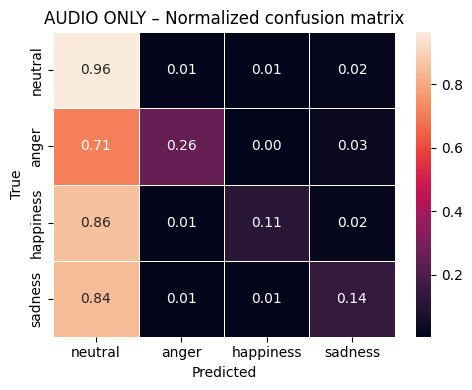


=== AUDIO + TRANSCRIPT ===
Accuracy          : 0.4626728110599078
Balanced accuracy : 0.3824972180366948
Macro F1          : 0.3696227073558494
Weighted F1       : 0.3983854918623413
Cohen's kappa     : 0.19624012859039763
MCC               : 0.2863937166904547

Classification report:
              precision    recall  f1-score   support

     neutral       0.41      0.96      0.57       384
       anger       0.91      0.23      0.37       229
   happiness       0.87      0.17      0.29       278
     sadness       0.52      0.16      0.25       194

    accuracy                           0.46      1085
   macro avg       0.68      0.38      0.37      1085
weighted avg       0.65      0.46      0.40      1085



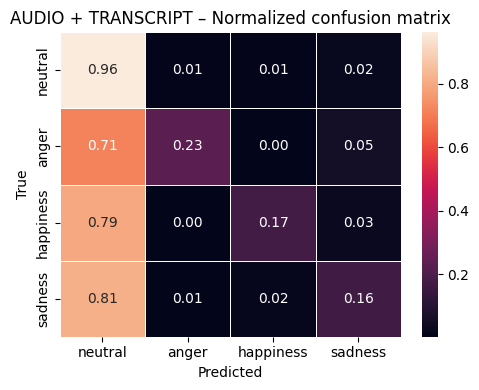

In [13]:
# ============================================
# 10. EVALUATION METRICS & CONFUSION MATRICES
# ============================================
y_true = df_eval["label"].tolist()
y_a    = df_eval["pred_audio"].tolist()
y_b    = df_eval["pred_bimodal"].tolist()

def compute_metrics(y_true, y_pred, prefix=""):
    print(f"\n=== {prefix} ===")
    print("Accuracy          :", accuracy_score(y_true, y_pred))
    print("Balanced accuracy :", balanced_accuracy_score(y_true, y_pred))
    print("Macro F1          :", f1_score(y_true, y_pred, average="macro"))
    print("Weighted F1       :", f1_score(y_true, y_pred, average="weighted"))
    print("Cohen's kappa     :", cohen_kappa_score(y_true, y_pred))
    print("MCC               :", matthews_corrcoef(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, labels=LABEL_LIST, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=LABEL_LIST)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        xticklabels=LABEL_LIST,
        yticklabels=LABEL_LIST,
        linewidths=0.5,
    )
    plt.title(f"{prefix} – Normalized confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

compute_metrics(y_true, y_a, prefix="AUDIO ONLY")
compute_metrics(y_true, y_b, prefix="AUDIO + TRANSCRIPT")


In [14]:
# ============================================
# 11. NEUTRAL-BIAS ANALYSIS
# ============================================
SER_TRUE = pd.Series(y_true, name="true")
SER_A    = pd.Series(y_a, name="pred_audio")
SER_B    = pd.Series(y_b, name="pred_bimodal")

print("Label distribution (ground truth):")
print(SER_TRUE.value_counts(), "\n")

print("Prediction distribution – AUDIO ONLY:")
print(SER_A.value_counts(), "\n")

print("Prediction distribution – AUDIO + TRANSCRIPT:")
print(SER_B.value_counts(), "\n")

for name, ser in [("AUDIO ONLY", SER_A), ("AUDIO+TRANSCRIPT", SER_B)]:
    total = len(ser)
    neu   = (ser == "neutral").sum()
    print(f"{name}: neutral predictions = {neu}/{total} ({neu/total:.3f})")


Label distribution (ground truth):
true
neutral      384
happiness    278
anger        229
sadness      194
Name: count, dtype: int64 

Prediction distribution – AUDIO ONLY:
pred_audio
neutral      933
anger         70
sadness       46
happiness     36
Name: count, dtype: int64 

Prediction distribution – AUDIO + TRANSCRIPT:
pred_bimodal
neutral      911
sadness       61
anger         58
happiness     55
Name: count, dtype: int64 

AUDIO ONLY: neutral predictions = 933/1085 (0.860)
AUDIO+TRANSCRIPT: neutral predictions = 911/1085 (0.840)


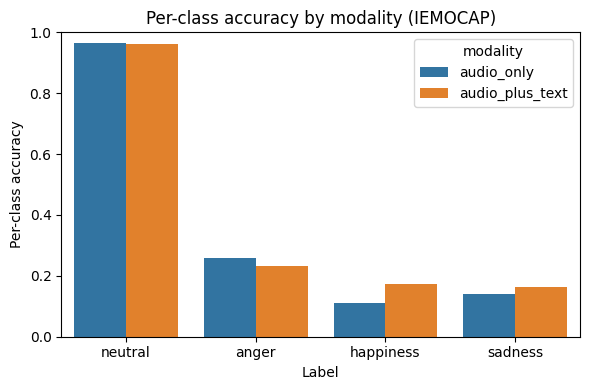

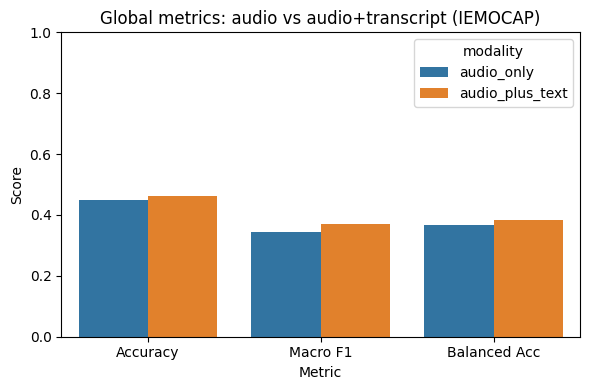

In [15]:
# ============================================
# 12. PER-CLASS ACCURACY & GLOBAL METRIC BARPLOTS
# ============================================
def per_label_accuracy(y_true, y_pred, labels):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accs = {}
    for lab in labels:
        mask = (y_true == lab)
        if mask.sum() == 0:
            accs[lab] = np.nan
        else:
            accs[lab] = (y_pred[mask] == y_true[mask]).mean()
    return accs

acc_audio = per_label_accuracy(y_true, y_a, LABEL_LIST)
acc_both  = per_label_accuracy(y_true, y_b, LABEL_LIST)

df_acc = pd.DataFrame({
    "label": LABEL_LIST,
    "audio_only":     [acc_audio[l] for l in LABEL_LIST],
    "audio_plus_text": [acc_both[l] for l in LABEL_LIST],
})

df_acc_melt = df_acc.melt(id_vars="label", var_name="modality", value_name="accuracy")

plt.figure(figsize=(6, 4))
sns.barplot(data=df_acc_melt, x="label", y="accuracy", hue="modality")
plt.ylim(0, 1)
plt.xlabel("Label")
plt.ylabel("Per-class accuracy")
plt.title("Per-class accuracy by modality (IEMOCAP)")
plt.tight_layout()
plt.show()

def global_scores(y_true, y_pred):
    return {
        "Accuracy":          accuracy_score(y_true, y_pred),
        "Macro F1":          f1_score(y_true, y_pred, average="macro"),
        "Balanced Acc":      balanced_accuracy_score(y_true, y_pred),
    }

scores_audio = global_scores(y_true, y_a)
scores_both  = global_scores(y_true, y_b)

df_scores = pd.DataFrame({
    "metric":       list(scores_audio.keys()),
    "audio_only":   list(scores_audio.values()),
    "audio_plus_text": list(scores_both.values()),
})

df_scores_melt = df_scores.melt(id_vars="metric", var_name="modality", value_name="score")

plt.figure(figsize=(6, 4))
sns.barplot(data=df_scores_melt, x="metric", y="score", hue="modality")
plt.ylim(0, 1)
plt.xlabel("Metric")
plt.ylabel("Score")
plt.title("Global metrics: audio vs audio+transcript (IEMOCAP)")
plt.tight_layout()
plt.show()


In [16]:
# ============================================
# 13. ERROR ANALYSIS (WHERE TEXT HELPS / HURTS)
# ============================================
df_eval["correct_audio"]   = df_eval["pred_audio"]   == df_eval["label"]
df_eval["correct_bimodal"] = df_eval["pred_bimodal"] == df_eval["label"]

improved = df_eval[(~df_eval["correct_audio"]) & (df_eval["correct_bimodal"])]
worsened = df_eval[(df_eval["correct_audio"]) & (~df_eval["correct_bimodal"])]

print("\n# samples where transcript FIXED an error:", len(improved))
print(improved["label"].value_counts())
print("\n# samples where transcript BROKE a correct prediction:", len(worsened))
print(worsened["label"].value_counts())

print("\nExamples improved by text (first 10):")
display(improved[["utt_id", "label", "pred_audio", "pred_bimodal", "transcription"]].head(10))

print("\nExamples worsened by text (first 10):")
display(worsened[["utt_id", "label", "pred_audio", "pred_bimodal", "transcription"]].head(10))



# samples where transcript FIXED an error: 30
label
happiness    18
sadness       5
neutral       4
anger         3
Name: count, dtype: int64

# samples where transcript BROKE a correct prediction: 15
label
anger        9
neutral      5
happiness    1
Name: count, dtype: int64

Examples improved by text (first 10):


,utt_id,label,pred_audio,pred_bimodal,transcription
55,Ses01M_script01_1_F024,anger,neutral,anger,From father's point of view he is not dead and...
80,Ses01M_script01_1_M023,anger,neutral,anger,To hell with that.
92,Ses01F_script03_2_F004,neutral,anger,neutral,I did not. You worked that whole thing up in ...
178,Ses01M_impro07_M002,happiness,neutral,happiness,For softball. They're going to pay me to go t...
241,Ses01F_impro02_M013,sadness,neutral,sadness,I just don't know how I'm going to do it witho...
253,Ses01M_script01_3_F015,happiness,anger,happiness,"Because I was waiting for you, Chris. Till th..."
337,Ses01F_script01_3_F011,happiness,neutral,happiness,[LAUGHTER]
371,Ses01F_script01_3_M026,sadness,neutral,sadness,Well I lost them.
399,Ses01F_script02_1_M016,happiness,neutral,happiness,"God, I'm so excited, I'm like a kid. I can't ..."
527,Ses01M_impro02_M021,sadness,neutral,sadness,I just wish there was something I could do.



Examples worsened by text (first 10):


,utt_id,label,pred_audio,pred_bimodal,transcription
144,Ses01F_script03_2_M036,anger,anger,neutral,Oh. That's very amusing indeed.
212,Ses01M_impro01_M020,anger,anger,neutral,Did you even look at the form? I filled it ou...
213,Ses01M_impro01_M025,anger,anger,neutral,I am not...I'm not getting to back that line.
315,Ses01M_impro04_F018,neutral,neutral,anger,We're trying to have a conversation and you se...
403,Ses01F_script02_1_M024,neutral,neutral,happiness,"Honey, this is like a natural phenomenon. I me..."
407,Ses01F_script02_1_M031,neutral,neutral,sadness,"God, I don't get it. you know the first time ..."
447,Ses01F_script01_2_F011,anger,anger,neutral,I won't stand for any nonsense.
698,Ses01F_script01_1_F005,neutral,neutral,sadness,"He's dreaming of him again, walking around."
799,Ses01M_script02_2_F015,anger,anger,neutral,No we won't. It's pointless it's like a waiti...
834,Ses01M_script02_2_M033,anger,anger,neutral,"A new carpet, a poodle, a suicide pact, ice cr..."


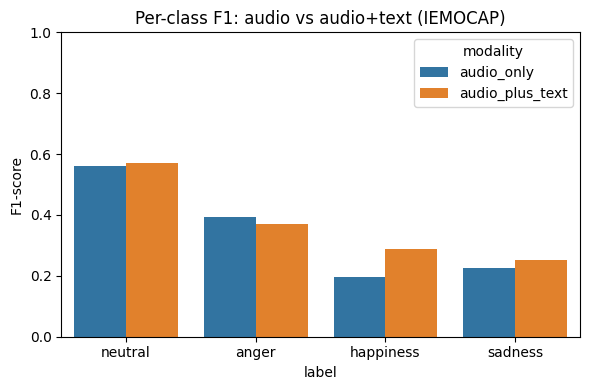


Per-class F1 comparison (audio vs audio+text):
           F1_audio  F1_audio+text  Delta(text-audio)
label                                                
neutral       0.562          0.570              0.008
anger         0.395          0.369             -0.025
happiness     0.197          0.288              0.091
sadness       0.225          0.251              0.026

Sample-level correctness breakdown:
 Both correct          : 472
 Audio only correct    : 15
 Audio+text only       : 30
 Both wrong            : 568


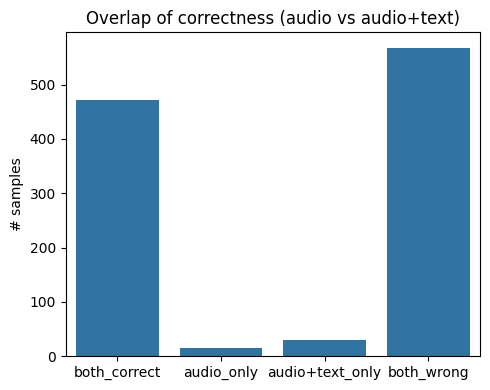

In [17]:
# ============================================
# 14. PER-CLASS F1 & OVERLAP OF CORRECTNESS
# ============================================
def clf_report_df(y_true, y_pred, labels, modality):
    rep = classification_report(
        y_true, y_pred, labels=labels, output_dict=True, zero_division=0
    )
    df_rep = pd.DataFrame(rep).T
    df_rep = df_rep.loc[labels, ["precision", "recall", "f1-score"]]
    df_rep["label"]    = df_rep.index
    df_rep["modality"] = modality
    return df_rep

rep_a = clf_report_df(y_true, y_a, LABEL_LIST, "audio_only")
rep_b = clf_report_df(y_true, y_b, LABEL_LIST, "audio_plus_text")

df_rep = pd.concat([rep_a, rep_b], ignore_index=True)

df_rep_melt = df_rep.melt(
    id_vars=["label", "modality"],
    value_vars=["precision", "recall", "f1-score"],
    var_name="metric",
    value_name="value",
)

# F1-only barplot
plt.figure(figsize=(6, 4))
sns.barplot(
    data=df_rep_melt[df_rep_melt["metric"] == "f1-score"],
    x="label",
    y="value",
    hue="modality",
)
plt.ylim(0, 1)
plt.title("Per-class F1: audio vs audio+text (IEMOCAP)")
plt.ylabel("F1-score")
plt.tight_layout()
plt.show()

f1_a = rep_a.set_index("label")["f1-score"]
f1_b = rep_b.set_index("label")["f1-score"]
df_f1_delta = pd.DataFrame({
    "F1_audio":        f1_a,
    "F1_audio+text":   f1_b,
    "Delta(text-audio)": f1_b - f1_a,
})
print("\nPer-class F1 comparison (audio vs audio+text):")
print(df_f1_delta.round(3))

# sample-level correctness overlap
y_true_arr = np.array(y_true)
y_a_arr    = np.array(y_a)
y_b_arr    = np.array(y_b)

correct_a = (y_a_arr == y_true_arr)
correct_b = (y_b_arr == y_true_arr)

both_correct       = np.sum(correct_a & correct_b)
audio_only_correct = np.sum(correct_a & ~correct_b)
bimodal_only       = np.sum(~correct_a & correct_b)
both_wrong         = np.sum(~correct_a & ~correct_b)

print("\nSample-level correctness breakdown:")
print(f" Both correct          : {both_correct}")
print(f" Audio only correct    : {audio_only_correct}")
print(f" Audio+text only       : {bimodal_only}")
print(f" Both wrong            : {both_wrong}")

plt.figure(figsize=(5, 4))
sns.barplot(
    x=["both_correct", "audio_only", "audio+text_only", "both_wrong"],
    y=[both_correct, audio_only_correct, bimodal_only, both_wrong],
)
plt.ylabel("# samples")
plt.title("Overlap of correctness (audio vs audio+text)")
plt.tight_layout()
plt.show()


In [18]:
# ============================================
# 15. GENDER COLUMN (FROM utt_id) + GENDER ANALYSIS
# ============================================
def infer_gender_from_utt(utt: str) -> str:
    """
    IEMOCAP utt_id starts with something like 'Ses01F' or 'Ses02M'.
    We infer the gender from the last char of that session token.
    """
    if not isinstance(utt, str):
        return "unknown"
    try:
        sess = utt.split("_")[0]  # e.g. 'Ses01F'
        g    = sess[-1]
        if g == "F":
            return "female"
        elif g == "M":
            return "male"
        else:
            return "unknown"
    except Exception:
        return "unknown"

df_eval["gender"] = df_eval["utt_id"].apply(infer_gender_from_utt)
print("Gender distribution in df_eval:")
print(df_eval["gender"].value_counts())


Gender distribution in df_eval:
gender
male      578
female    507
Name: count, dtype: int64


Using gender column: gender
gender
male      578
female    507
Name: count, dtype: int64 

Global metrics by gender & modality:


metric                  Accuracy  Balanced Acc  Macro F1
gender modality                                         
female audio_only          0.536         0.391     0.398
       audio_plus_text     0.558         0.418     0.440
male   audio_only          0.372         0.355     0.302
       audio_plus_text     0.379         0.360     0.314

/tmp/ipython-input-2786899468.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_gender, x="metric", y="score", hue="modality", ci=None)


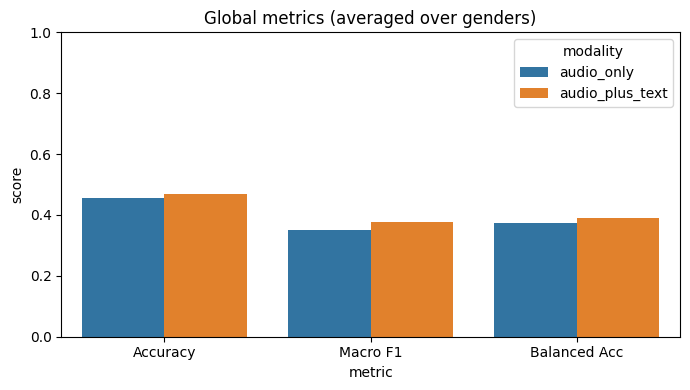


Per-class F1 by gender & modality (head):
   gender      label         modality     F1
0  female    neutral       audio_only  0.655
1  female    neutral  audio_plus_text  0.666
2  female      anger       audio_only  0.431
3  female      anger  audio_plus_text  0.416
4  female  happiness       audio_only  0.211


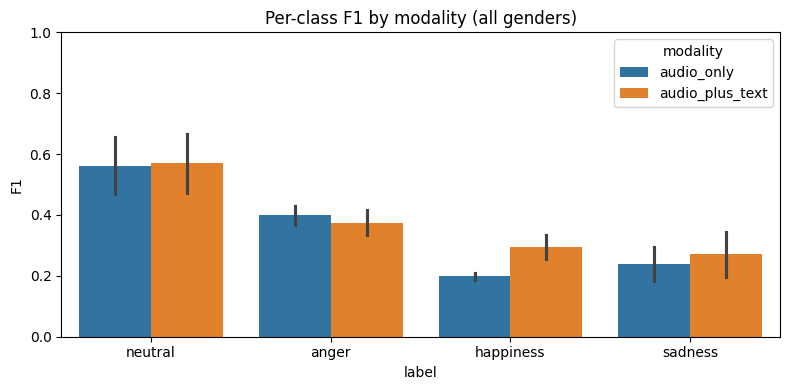

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)


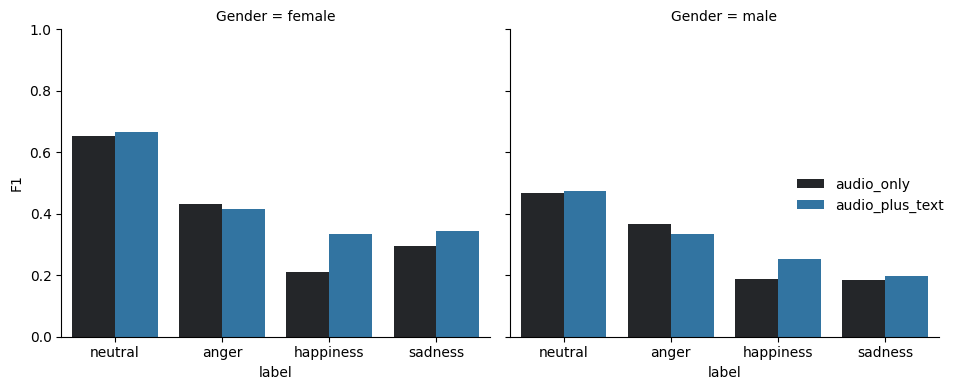

In [19]:
# ============================================
# 16. GENDER-BASED METRIC COMPARISON
# ============================================
possible_gender_cols = ["gender", "speaker_gender", "sex"]
GENDER_COL = None
for c in possible_gender_cols:
    if c in df_eval.columns:
        GENDER_COL = c
        break

if GENDER_COL is None:
    raise ValueError(
        "No gender column found in df_eval; add one (e.g., 'gender') before running this cell."
    )

print(f"Using gender column: {GENDER_COL}")
print(df_eval[GENDER_COL].value_counts(), "\n")

def global_scores(y_true, y_pred):
    return {
        "Accuracy":          accuracy_score(y_true, y_pred),
        "Macro F1":          f1_score(y_true, y_pred, average="macro", zero_division=0),
        "Balanced Acc":      balanced_accuracy_score(y_true, y_pred),
    }

# global metrics per gender & modality
rows = []
for g in sorted(df_eval[GENDER_COL].unique()):
    mask = df_eval[GENDER_COL] == g
    y_true_g = df_eval.loc[mask, "label"].tolist()
    y_a_g    = df_eval.loc[mask, "pred_audio"].tolist()
    y_b_g    = df_eval.loc[mask, "pred_bimodal"].tolist()

    s_audio = global_scores(y_true_g, y_a_g)
    s_both  = global_scores(y_true_g, y_b_g)

    for metric, val in s_audio.items():
        rows.append({"gender": g, "modality": "audio_only",     "metric": metric, "score": val})
    for metric, val in s_both.items():
        rows.append({"gender": g, "modality": "audio_plus_text", "metric": metric, "score": val})

df_gender = pd.DataFrame(rows)

print("Global metrics by gender & modality:")
display(
    df_gender
    .pivot_table(index=["gender", "modality"], columns="metric", values="score")
    .round(3)
)

plt.figure(figsize=(7, 4))
sns.barplot(data=df_gender, x="metric", y="score", hue="modality", ci=None)
plt.ylim(0, 1)
plt.title("Global metrics (averaged over genders)")
plt.tight_layout()
plt.show()

# per-class F1 by gender & modality
rows = []
for g in sorted(df_eval[GENDER_COL].unique()):
    mask = df_eval[GENDER_COL] == g
    y_true_g = df_eval.loc[mask, "label"].tolist()
    y_a_g    = df_eval.loc[mask, "pred_audio"].tolist()
    y_b_g    = df_eval.loc[mask, "pred_bimodal"].tolist()

    rep_a_g = classification_report(
        y_true_g, y_a_g, labels=LABEL_LIST, output_dict=True, zero_division=0
    )
    rep_b_g = classification_report(
        y_true_g, y_b_g, labels=LABEL_LIST, output_dict=True, zero_division=0
    )

    for lab in LABEL_LIST:
        rows.append({
            "gender":   g,
            "label":    lab,
            "modality": "audio_only",
            "F1":       rep_a_g[lab]["f1-score"],
        })
        rows.append({
            "gender":   g,
            "label":    lab,
            "modality": "audio_plus_text",
            "F1":       rep_b_g[lab]["f1-score"],
        })

df_gender_f1 = pd.DataFrame(rows)
print("\nPer-class F1 by gender & modality (head):")
print(df_gender_f1.head().round(3))

plt.figure(figsize=(8, 4))
sns.barplot(
    data=df_gender_f1,
    x="label",
    y="F1",
    hue="modality",
)
plt.ylim(0, 1)
plt.title("Per-class F1 by modality (all genders)")
plt.tight_layout()
plt.show()

g = sns.FacetGrid(df_gender_f1, col="gender", height=4, sharey=True)
g.map_dataframe(sns.barplot, x="label", y="F1", hue="modality")
g.add_legend()
g.set_titles(col_template="Gender = {col_name}")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [20]:
# ============================================
# 17. SUMMARY ROW FOR CROSS-DATASET COMPARISON
# ============================================
DATASET_NAME = "IEMOCAP_EmoBox_test_fold1"

def summary_row(dataset_name: str, modality: str, y_true, y_pred) -> dict:
    ser_pred = pd.Series(y_pred)
    neutral_frac = (ser_pred == "neutral").mean()
    gs = global_scores(y_true, y_pred)
    return {
        "dataset": dataset_name,
        "modality": modality,
        "accuracy": gs["Accuracy"],
        "macro_f1": gs["Macro F1"],
        "balanced_acc": gs["Balanced Acc"],
        "neutral_frac": neutral_frac,
    }

summary_rows = [
    summary_row(DATASET_NAME, "audio_only",     y_true, y_a),
    summary_row(DATASET_NAME, "audio_plus_text", y_true, y_b),
]

df_summary = pd.DataFrame(summary_rows)
print("\n=== SUMMARY (for cross-dataset comparison) ===")
display(df_summary.round(4))



=== SUMMARY (for cross-dataset comparison) ===


,dataset,modality,accuracy,macro_f1,balanced_acc,neutral_frac
0,IEMOCAP_EmoBox_test_fold1,audio_only,0.4488,0.3447,0.3680,0.8599
1,IEMOCAP_EmoBox_test_fold1,audio_plus_text,0.4627,0.3696,0.3825,0.8396
